# Mammogram classifier

## Project's goal

Predict whether a mammogram mass is benign or malignant. 

## Data 

The data used for this project comes from the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass). 

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

1. BI-RADS assessment (ordinal) - 1 to 5 
2. Age (integer) - Patient's age in years 
3. Mass shape (nominal)- Mass shape: round=1 oval=2 lobular=3 irregular=4 
4. Mass margin (nominal) - circumscribed=1; micro-lobulated=2; obscured=3; ill-defined=4; spiculated=5
5. Mass density (ordinal) - high=1; iso=2; low=3; fat-containing=4 
6. Severity (binomial) - benign=0 or malignant=1

## Methodology

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Models tested:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* Neural network using Keras

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

## Data pre-processing

In [69]:
import pandas as pd

data = pd.read_csv('mammographic_masses.data.txt')
data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Load data converting missing data (indicated by "?") into NaN values and add appropriate column names. 

In [70]:
data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [71]:
data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [72]:
# Let's look at the missing values

data.loc[(data['age'].isnull()) |
        (data['shape'].isnull()) |
        (data['margin'].isnull()) |
        (data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


1.0     16
2.0     59
3.0    798
4.0     12
Name: density, dtype: int64


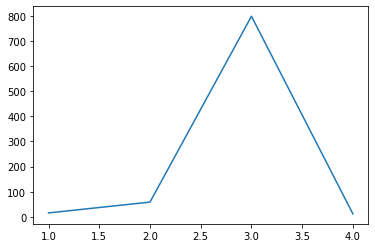

In [73]:
# Check if the missing data is randomly distributed or if it appears there's anyt sort of correlation.

attribute = "age"    # check every attribute
distribution = data[attribute].value_counts().sort_index()
print(distribution)

import matplotlib.pyplot as plt
X = distribution.index
Y = distribution.values
plt.plot(X,Y)

Missing data seems randomly distributed. 

In [74]:
# Drop missing values. 

data.dropna(inplace=True)
data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Droping missing values reduces our dataset from 961 to 830 instances which seems acceptable.  
Now, let's convert the dataframe into NumPy arrays that can be used by scikit-learn :
* An array X containing data of predictive features (age, shape, margin and density).
* An array Y containing classification data (severity).

N.B : The attribute BI-RADS (assessment of how confident the severity classfication is) has been dropped because it is not a "predictive" attribute. 

In [75]:
feature_names = ['age', 'shape', 'margin', 'density']
X = data[feature_names].values
Y = data['severity'].values

X

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Now let's do the last data pre-processing steps 

* Normization (some models require the input data to be normalized).

N.B : No need of creating Train/Test datasets, we will directly use K-fold cross validation to increase performances reliability and avoid overfitting. 

In [76]:
# Input data normalization

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

# Logistic Regression

One of the simplest and most straightforward model for binary classification. 

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
score = cv_scores.mean()

# Save score in a scores matrix
scores = pd.DataFrame(columns=['Model', 'Score'])
scores.loc[0] = ['Logistic Regression', score]
scores

,Model,Score
0,Logistic Regression,0.807229


# KNN

In [78]:
from sklearn import neighbors

# Try with K ranging from 1 to 50 
results = pd.DataFrame(columns=['K value', 'Score'])
for k in range(1, 50):
    model = neighbors.KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
    results.loc[k] = [int(k), cv_scores.mean()]
    
results['Score'].sort_values(ascending=False)

7     0.795181
49    0.791566
10    0.791566
9     0.790361
48    0.790361
30    0.790361
11    0.789157
47    0.789157
32    0.789157
13    0.787952
33    0.787952
21    0.787952
14    0.786747
15    0.786747
28    0.786747
31    0.786747
25    0.786747
34    0.786747
36    0.786747
38    0.786747
29    0.785542
27    0.785542
26    0.785542
22    0.785542
20    0.785542
37    0.784337
46    0.784337
19    0.784337
40    0.784337
12    0.783133
35    0.783133
45    0.783133
16    0.783133
42    0.781928
39    0.781928
44    0.781928
41    0.780723
43    0.780723
17    0.778313
18    0.778313
24    0.778313
23    0.778313
8     0.777108
5     0.771084
6     0.768675
3     0.754217
4     0.734940
1     0.732530
2     0.690361
Name: Score, dtype: float64

In [79]:
# K=7 achieve a score around 0.795. K=9,10 and 11 have also good performances (around 0,79)

scores.loc[1] = ['KNN', 0.795]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795000


# Naive Bayes

In [80]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
X_minmax = scaler.fit_transform(X)

model = MultinomialNB()
cv_scores = cross_val_score(model, X_minmax, Y, cv=10)

score = cv_scores.mean()

scores.loc[2] = ['Naive Bayes', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795000
2,Naive Bayes,0.785542


# Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=1)
cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
score = cv_scores.mean()

scores.loc[3] = ['Decision Tree', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795000
2,Naive Bayes,0.785542
3,Decision Tree,0.737349


# Random Forest 

In [82]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, random_state=1)
cv_scores = cross_val_score(model, X_scaled, Y, cv=10)

score = cv_scores.mean()

scores.loc[4] = ['Random Forest', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795000
2,Naive Bayes,0.785542
3,Decision Tree,0.737349
4,Random Forest,0.742169


# SVM

In [83]:
from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = pd.DataFrame(columns=['Kernel', 'Score'])
k = 0
for kernel in kernels:
    model = svm.SVC(kernel='linear', C=1.0)
    cv_scores = cross_val_score(model, X_scaled, Y, cv=10)
    results.loc[k] = [kernel, cv_scores.mean()]
    k += 1
results

,Kernel,Score
0,linear,0.79759
1,poly,0.79759
2,rbf,0.79759
3,sigmoid,0.79759


In [84]:
scores.loc[5] = ['SVM', 0.79759]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795000
2,Naive Bayes,0.785542
3,Decision Tree,0.737349
4,Random Forest,0.742169
5,SVM,0.797590


# Neural Network 

In [89]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    # Input Layer - 4 feature inputs into a 6-unit layer 
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # Hidden layer 1 (turns out to be inefficient)
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer - single neuron layer with sigmoid activation (binary classification)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [90]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

# Use scikit_learn's cross_val_score to evaluate performances
cv_scores = cross_val_score(estimator, X_scaled, Y, cv=10)
score = cv_scores.mean()

scores.loc[6] = ['Neural Network', score]
scores

,Model,Score
0,Logistic Regression,0.807229
1,KNN,0.795000
2,Naive Bayes,0.785542
3,Decision Tree,0.737349
4,Random Forest,0.742169
5,SVM,0.797590
6,Neural Network,0.804819
